In [ ]:
import os, glob, scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import cv2
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout #Dense 층을 만들기위함(많이쓸듯)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #좋은 모델 기억
from tensorflow.keras.models import load_model# 모델 불러오기
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
 
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


#사진 흑백으로 저장 필요할 시

path = "./data_(1)/Free(1)/"
imagePaths = [os.path.join(path,file_name) for file_name in os.listdir(path)]
count = 0
for imagePath in imagePaths:
    count += 1
    img = Image.open(imagePath)
    img_numpy = np.array(img, 'uint8')
    gray = cv2.cvtColor(img_numpy, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("./data_(1)/Free(1)/" + str(count) + ".jpg" , gray)
print("All Done")


#사진 흑백으로 저장 필요할 시

path = "./data_(1)/Full(1)/"
imagePaths = [os.path.join(path,file_name) for file_name in os.listdir(path)]
count = 0
for imagePath in imagePaths:
    count += 1
    img = Image.open(imagePath)
    img_numpy = np.array(img, 'uint8')
    gray = cv2.cvtColor(img_numpy, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("./data_(1)/Full(1)/" + str(count) + ".jpg" , gray)
print("All Done")

#사진 흑백으로 저장 필요할 시

path = "./data_(1)/test/"
imagePaths = [os.path.join(path,file_name) for file_name in os.listdir(path)]
count = 0
for imagePath in imagePaths:
    count += 1
    img = Image.open(imagePath)
    img_numpy = np.array(img, 'uint8')
    gray = cv2.cvtColor(img_numpy, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("./data_(1)/test/" + str(count) + ".jpg" , gray)
print("All Done")

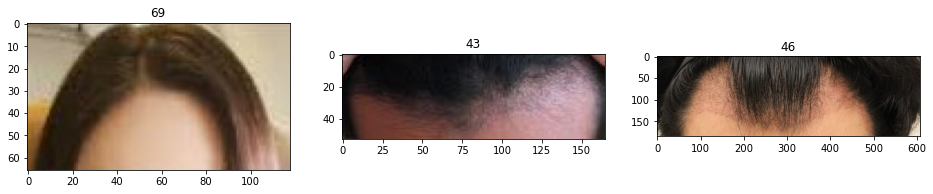

In [2]:
#데이터 불러오기

BASE_PATH = 'data(m자)'

full_list = glob.glob(os.path.join(BASE_PATH, '정상/*.jpg'))
middle_list = glob.glob(os.path.join(BASE_PATH, '주의/*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, '심각/*.jpg'))



full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
middle_img = img_to_array(load_img(middle_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

#각 첫번쨰 이미지 확인
plt.figure(figsize=(16, 16))
plt.subplot(1, 3, 1)
plt.title(len(full_list))
plt.imshow(full_img)
plt.subplot(1, 3, 2)
plt.title(len(middle_list))
plt.imshow(middle_img)
plt.subplot(1, 3, 3)
plt.title(len(free_list))
plt.imshow(free_img)


# DataGenerator

In [3]:
#데이터 라벨링

#90% 학습용 10% 검증용

#preprocess_input (이미지 정규화)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)
#데이터 불러온 후 resize
#라벨링
train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['정상','주의','심각'],
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['정상','주의','심각'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)
print(train_gen.class_indices)
print(val_gen.class_indices)

Found 455 images belonging to 3 classes.
Found 49 images belonging to 3 classes.
{'정상': 0, '주의': 1, '심각': 2}
{'정상': 0, '주의': 1, '심각': 2}


In [4]:
#Transfer learning(전이학습)
#MobileNetV2 에선 모바일 기기에서 사용가능하도록 메모리와 연산량을 감소시켰으나 기존 모델의 정확도를 유지

base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)


x = base_model.output
x = GlobalAveragePooling2D()(x)

#3가지 분류
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [5]:
for layer in model.layers:
    layer.trainable = True

In [81]:
#정확도 95%
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    
    callbacks=[
        ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 0.4752 - acc: 0.8132
Epoch 00001: val_acc improved from -inf to 0.55102, saving model to model.h5
15/15 [==============================] - 10s 637ms/step - loss: 0.4752 - acc: 0.8132 - val_loss: 5.2735 - val_acc: 0.5510
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 0.2190 - acc: 0.9165
Epoch 00002: val_acc improved from 0.55102 to 0.65306, saving model to model.h5
15/15 [==============================] - 8s 501ms/step - loss: 0.2190 - acc: 0.9165 - val_loss: 2.5465 - val_acc: 0.6531
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 0.1255 - acc: 0.9495
Epoch 00003: val_acc improved from 0.65306 to 0.71429, saving model to model.h5
15/15 [==============================] - 7s 491ms/step - loss: 0.1255 - acc: 0.9495 - val_loss: 2.1875 - val_acc: 0.7143
Epoch 4/50
15/15 [==============================] - ETA: 0s - loss: 0.0707 - acc: 0.9714
Epoch 00004: val_acc improved from 0.71429 

In [6]:
#모델의 마지막 레이어에 웨이트를 불러옴
#공간적인 특징이 있는 레이어를 써야함
#global_average_pooling2d 을 통과하면 특징들이 사라지기 때문에
#공간적인 특징이 있는 out_relu (ReLU),dense (Dense) 레이어를 사용
model = load_model('model.h5')

last_weight = model.layers[-1].get_weights()[0] 

new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, 
        model.layers[-1].output
    )
)

new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [10]:
path_dir = 'C:/Users/dz3kz/project(m자 탈모)/test' # flask저장경로로 바꿔줌
 
file_list = os.listdir(path_dir)
print(file_list)

['12.jpg', '135.jpg', '192.jpg', '206.png', '208.png', '210.png', '217.png', '232.jpg', '234.jpg', '240.jpg', '74.jpg', '예쁜 이마 라인_564.jpg', '예쁜 이마 라인_566.jpg', '예쁜 이마 라인_569.jpg', '예쁜 이마 라인_574.jpg', '예쁜 이마 라인_598.jpg']


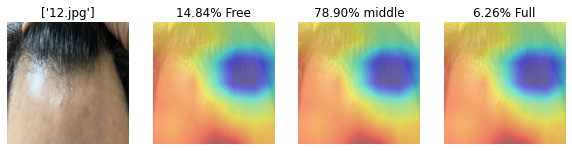

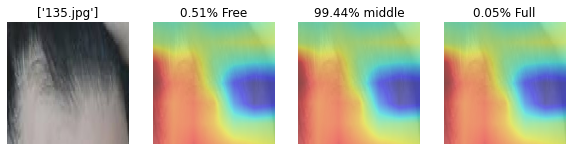

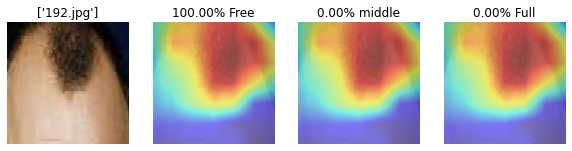

KeyboardInterrupt: 

In [11]:
parking_list=file_list

for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(path_dir, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)

    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) #(7,7)
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 
    
    
    #라벨들 확인
    pred_class = np.argmax(pred)  #0 : 양호 1 : 주의  2 : 경계
    predicted_class_weights = last_weight[:, pred_class] 

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    
    
    fig, ax = plt.subplots(nrows=1, ncols=4)
    fig.set_size_inches(10,5)

    
    #, 를 기준으로 파일명 분리
    ax[0].imshow(test_img.astype(np.uint8))
    ax[0].set_title(parking.split(','))
    ax[0].axis('off')
    
    
    #심각
    ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
    ax[1].imshow(final_output, cmap='jet', alpha=0.5)
    ax[1].set_title('%.2f%% Free' % (pred[0][2]*100))
    ax[1].axis('off')
    
    #주의
    ax[2].imshow(test_img.astype(np.uint8), alpha=0.5)
    ax[2].imshow(final_output, cmap='jet', alpha=0.5)
    ax[2].set_title('%.2f%% middle' % (pred[0][1]*100))
    ax[2].axis('off')
    
    #양호
    ax[3].imshow(test_img.astype(np.uint8), alpha=0.5)
    ax[3].imshow(final_output, cmap='jet', alpha=0.5)
    ax[3].set_title('%.2f%% Full' % (pred[0][0]*100))
    ax[3].axis('off')
    
    
  
    
    plt.show()